Model Training done by  Ng Aik Keong Sebastian 2400871

Importing of Libraries

In [16]:
import numpy as np
import pandas as pd
#import category_encoders as ce

from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import hstack, csr_matrix

from hyperopt import fmin, tpe, hp, Trials

from skopt import BayesSearchCV

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

#import pickle
import joblib
#from joblib import dump, load
import os

Reading Excel data file (in the data folder)

In [2]:
df = pd.read_csv("../data/cleanedData.csv")

Separate target(label) from predictor columns

In [3]:
y = df.label

Vectoriser is used to change strings into numerical values as the model is unable to take in string values

In [5]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['fullContent'])

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

sparse_features = csr_matrix(df[["urls", "totalLength", "generalConsumer", "govDomain", "eduDomain", "orgDomain", "netDomain", "otherDomain", "html", "punctuationCount"]].values)

X = hstack([sparse_features, tfidf_matrix])

Split full dataset into training set(80%) and testing set(20%)
<br>
8:2 Ratio is the standard in the coding scene

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Creating an XGBoost Classifier Model 
<br>
This will be my base model with the basic typical baseline configurations
<br>
Training the Model

In [6]:
clf = XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.01)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Evaluating the model’s performance

In [8]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy: ", accuracy)

Model accuracy:  0.9713253556107474


In [9]:
y_pred2 = clf.predict(X_train)
accuracy2 = accuracy_score(y_train, y_pred2)
print("Model accuracy:", accuracy2)

Model accuracy: 0.9766877398961391


Now that the base model is completed, i will move on to making modifications such as Hyperparameter tuning, Early stopping, Feature Engineering, Cross-Validation, Adressing Potential Overfitting

Tuning Hyperparameters (Guide)
<br>
1. Change of max depth from 3 to 4,5 however cannot change to much as it can cause overfitting
<br>
2. Change of learning rate and Estimators from 0.01 to 0.02, 0.05 while reducing the estimators proportionally such as 500 or 200
<br>
3. Using of subsample and colsample_bytree

ChatGPT:
I have a problem whereby i am unsure how i can tune my hyperparameters efficiently hence i promted GPT the following:
<br>
How to tune hyperparameters more efficiently instead of trying each parameter one by one
<br>
I was given a result of using the 3 methods:
<br>
1. Grid Search (Exhausive Search)
2. Randomized Search (Random Search)
3. Bayesian Optimization with scikit-optimize (skopt)
4. Hyperopt (Another Bayesian Optimization Tool)

Attempting Grid Search for Hyperparameter Tuning

In [45]:
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [47]:
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

Attempting Bayesian Optimization with scikit-optimize (skopt) for Hyperparameter Tuning

In [7]:
param_space = {
    'max_depth': (3, 10),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}

In [8]:
bayes_search = BayesSearchCV(estimator=XGBClassifier(), search_spaces=param_space, n_iter=10, cv=3, random_state=42)

bayes_search.fit(X_train, y_train)
print("Best parameters found: ", bayes_search.best_params_)
print("Best accuracy: ", bayes_search.best_score_)

KeyboardInterrupt: 

Attempting Random search
<br>
Reason for choosing random search is because grid search is exhausive and not optimal for larger parameter spaces whereas random search selects specified number of random combinations which makes it faster and more efficient in this scenario

These are values that i determined i wanted to try randomly searching through for combinations resulting in the best performing model

In [13]:
param_dist = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

1. Estimators is the model that i want to tune
2. Param dict is defined above which contains the hyperparameters and its ranges
3. Number of random parameter combinations to try
4. Number of coss validation checks
5. Verbosity level for logging progress
6. Random seed for reproducibility

In [14]:
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best accuracy:  0.9915895315467363


Serializing and Deserializing the python maching learning model as it takes 25 minutes to run and it will not be efficient to run it each time
<br>
The reason why i have opted for joblib and not pickle is because joblib is designed for handling a large numpy array and large dataset more efficiently

In [9]:
folder_path = '../best_params/'
randomSearch_model_filename = folder_path + 'XGBoost_random_sebastian.joblib'
bayesSearch_model_filename = folder_path + 'XGBoost_bayes_sebastian.joblib'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Seralizing the model

In [41]:
"""
dump(random_search, randomSearch_model_filename)
dump(bayes_search, bayesSearch_model_filename)
"""

['../model/XGBoost_bayes_sebastian.joblib']

Deserializing the model

In [10]:
random_search = load(randomSearch_model_filename)
bayes_search = load(bayesSearch_model_filename)

Fitting and making predictions using the saved hyperparameters from Random Search

In [11]:
print("Best Hyperparameters: " + str(random_search.best_params_))
random_search_best_params = random_search.best_params_
random_search_xgb_best_model = XGBClassifier(**random_search_best_params)
random_search_xgb_best_model.fit(X_train, y_train)
y_pred = random_search_xgb_best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the XGBoost model using Random Search: ", accuracy)

Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy of the XGBoost model using Random Search:  0.992323323549334


Confusion Matrix for Random Search XGBoost model

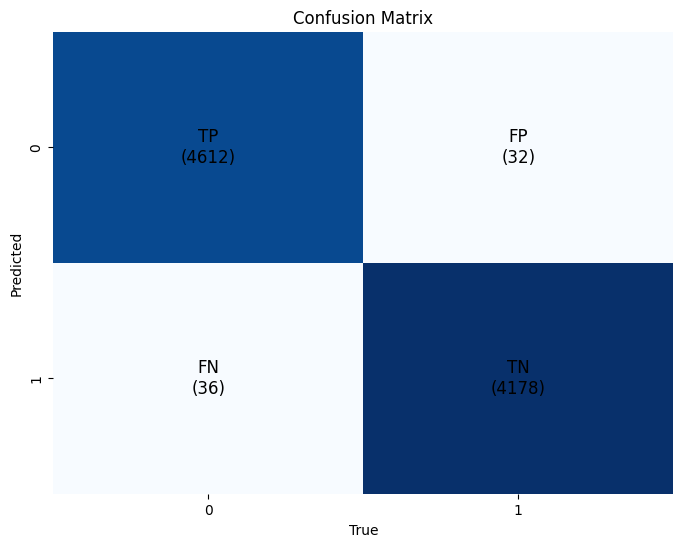

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)
ax.text(0.5, 0.5, 'TP\n(' + str(cm[1, 1]) + ')', ha='center', va='center', fontsize=12)
ax.text(1.5, 0.5, 'FP\n(' + str(cm[0, 1]) + ')', ha='center', va='center', fontsize=12)
ax.text(0.5, 1.5, 'FN\n(' + str(cm[1, 0]) + ')', ha='center', va='center', fontsize=12)
ax.text(1.5, 1.5, 'TN\n(' + str(cm[0, 0]) + ')', ha='center', va='center', fontsize=12)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

Fitting and making predictions using the saved hyperparameters from Bayes Search

In [13]:
print("Best Hyperparameters: " + str(bayes_search.best_params_))
bayes_search_best_params = bayes_search.best_params_
bayes_search_xgb_best_model = XGBClassifier(**bayes_search_best_params)
bayes_search_xgb_best_model.fit(X_train, y_train)
y_pred = bayes_search_xgb_best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the XGBoost model using Bayes Search: ", accuracy)

Best Hyperparameters: OrderedDict({'colsample_bytree': 0.7224162561505759, 'learning_rate': 0.22754356809600707, 'max_depth': 4, 'n_estimators': 490, 'reg_alpha': 0.1879551863673486, 'reg_lambda': 0.45366534380629897, 'subsample': 0.5777240270252717})
Accuracy of the XGBoost model using Bayes Search:  0.9922104312485889


Confusion Matrix for Bayes Search XGBoost model

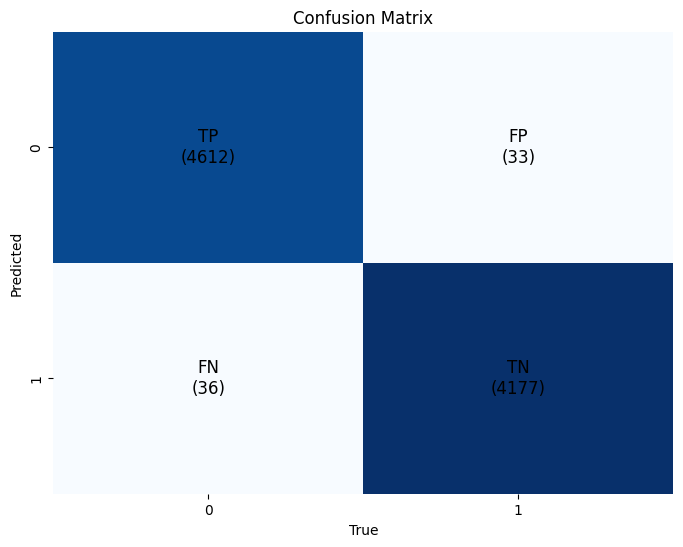

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)
ax.text(0.5, 0.5, 'TP\n(' + str(cm[1, 1]) + ')', ha='center', va='center', fontsize=12)
ax.text(1.5, 0.5, 'FP\n(' + str(cm[0, 1]) + ')', ha='center', va='center', fontsize=12)
ax.text(0.5, 1.5, 'FN\n(' + str(cm[1, 0]) + ')', ha='center', va='center', fontsize=12)
ax.text(1.5, 1.5, 'TN\n(' + str(cm[0, 0]) + ')', ha='center', va='center', fontsize=12)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

Reason for using Confusion Matrix
<br>
True Positive (TP): Correctly identified phishing emails.
<br>
False Positive (FP): Legitimate emails wrongly identified as phishing.
<br>
True Negative (TN): Correctly identified legitimate (non-phishing) emails.
<br>
False Negative (FN): Phishing emails wrongly classified as legitimate.

Overall Evaluation:
<br>
Precision is high (99.72%), meaning the model is very good at making sure emails it classifies as phishing are indeed phishing.
<br>
Recall is also high (97.96%), meaning the model does a great job of identifying phishing emails.
<br>
F1-Score is 98.83%, which indicates a great balance between precision and recall.
<br>
Accuracy is 99.91%, but keep in mind that accuracy may not be the best metric if the classes are imbalanced (e.g., if phishing emails are rare compared to non-phishing emails).

Testing if our classes are balanced

In [16]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique_train, counts_train))
unique_test, counts_test = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))
print("Class distribution in training data:", class_distribution_train)
print("Class distribution in test data:", class_distribution_test)

Class distribution in training data: {np.int64(0): np.int64(16571), np.int64(1): np.int64(18861)}
Class distribution in test data: {np.int64(0): np.int64(4210), np.int64(1): np.int64(4648)}


Class Ratios:
1. Training data: 16,571 non-phishing (47%), 18,861 phishing (53%)
2. Test data: 4,210 non-phishing (48%), 4,648 phishing (52%)

These percentages are almost equal, meaning that the classes are balanced. This is good because it indicates that the model won't be biased towards the majority class, and you can rely more on accuracy as a valid metric for evaluating the performance of the model.

In [17]:
print(classification_report(y_test, y_pred, target_names=['Non-Phishing', 'Phishing']))

              precision    recall  f1-score   support

Non-Phishing       0.99      0.99      0.99      4210
    Phishing       0.99      0.99      0.99      4648

    accuracy                           0.99      8858
   macro avg       0.99      0.99      0.99      8858
weighted avg       0.99      0.99      0.99      8858



In [15]:
folder_path = '../model/'
best_model_filename = folder_path + 'XGBoost_sebastian.joblib'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [17]:
joblib.dump(random_search_xgb_best_model, best_model_filename)

['../model/XGBoost_sebastian.joblib']

In [18]:
loaded_best_model = joblib.load(best_model_filename)

In [20]:
y_pred = loaded_best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best XGBoost model using Random Search: ", accuracy)

Accuracy of the XGBoost model using Bayes Search:  0.992323323549334
